# Imports

In [1029]:
import numpy as np
from matplotlib import pyplot as plt
from scipy.io import wavfile
from IPython.display import Audio
import logging
import sys
from random import choices
from scipy import signal
import torch
import os
import scipy.io.wavfile
from torch.utils.tensorboard import SummaryWriter
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils import data
from itertools import groupby
import random
from Levenshtein import distance
import matplotlib.patches as patches
from datetime import datetime

logging.basicConfig(
    format='%(asctime)s [%(levelname)s] %(name)s - %(message)s',
    level=logging.DEBUG,
    datefmt='%Y-%m-%d %H:%M:%S',
    stream=sys.stdout,
)
log = logging.getLogger('')
logging.getLogger("matplotlib").setLevel(logging.INFO)
logging.getLogger("librosa").setLevel(logging.INFO)

%load_ext tensorboard

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


# Dataset generation

## Utils

In [944]:
def generate_sine_wave(f, sr, duration):
    x = np.arange(duration * sr)
    y = np.sin(2 * np.pi * f * x / sr)
    return y


morse_code_dict = {
    '-----': '0',
    '.----': '1',
    '..---': '2',
    '...--': '3',
    '....-': '4',
    '.....': '5',
    '-....': '6',
    '--...': '7',
    '---..': '8',
    '----.': '9',
    '.-': 'A',
    '-...': 'B',
    '-.-.': 'C',
    '-..': 'D',
    '.': 'E',
    '..-.': 'F',
    '--.': 'G',
    '....': 'H',
    '..': 'I',
    '.---': 'J',
    '-.-': 'K',
    '.-..': 'L',
    '--': 'M',
    '-.': 'N',
    '---': 'O',
    '.--.': 'P',
    '--.-': 'Q',
    '.-.': 'R',
    '...': 'S',
    '-': 'T',
    '..-': 'U',
    '...-': 'V',
    '.--': 'W',
    '-..-': 'X',
    '-.--': 'Y',
    '--..': 'Z',
}

num_tags = len(morse_code_dict) + 1
tag_to_idx = {c: i + 1 for i, c in enumerate(list(morse_code_dict.values()) + [' '])}
idx_to_tag = {i + 1: c for i, c in enumerate(list(morse_code_dict.values()) + [' '])}


def find_key_by_value(dictionary, target_value):
    for key, value in dictionary.items():
        if value == target_value:
            return key
    return None


def char_to_morse(char):
    return find_key_by_value(morse_code_dict, char.upper())


def morse_char_to_signal(morse_char, dit_signal, dash_signal, dit_space_signal):
    packet = []

    for idx, v in enumerate(morse_char):
        if v == '-':
            packet = np.concatenate((packet, dash_signal))
        if v == '.':
            packet = np.concatenate((packet, dit_signal))
        if idx < len(morse_char) - 1:
            packet = np.concatenate((packet, dit_space_signal))

    return packet


def string_to_morse_signal(sentence, dit_signal, dash_signal, dit_space_signal, char_space_signal, word_space_signal):
    packet = []

    for _, c in enumerate(sentence):
        if c == ' ':
            packet = np.concatenate((packet, word_space_signal))
        else:
            char_signal = morse_char_to_signal(morse_char=char_to_morse(char=c),
                                               dit_signal=dit_signal,
                                               dash_signal=dash_signal,
                                               dit_space_signal=dit_space_signal)
            packet = np.concatenate((packet, char_signal))
            packet = np.concatenate((packet, char_space_signal))
    return packet


def apply_noise_and_channel(signal, channelResponse, SNRdb, rayleigh_dist=False):
    convolved = np.convolve(signal, channelResponse)
    signal_power = np.mean(abs(convolved ** 2))
    sigma2 = signal_power * 10 ** (-SNRdb / 10)  # calculate noise power based on signal power and SNR

    if rayleigh_dist:
        noise = np.sqrt(sigma2 / 2) * (np.random.rayleigh(*convolved.shape) + 1j * np.random.rayleigh(*convolved.shape))
    else:
        noise = np.sqrt(sigma2 / 2) * (np.random.randn(*convolved.shape) + 1j * np.random.randn(*convolved.shape))
    return convolved + noise


def save_packet_to_file(sr, packet, file_name='test', listen=False):
    packet_norm = np.int16(packet / np.max(np.abs(packet)) * 32000)
    filename = f'.//test_outputs//{file_name}.wav'
    wavfile.write(filename, sr, packet_norm)
    if listen:
        Audio(filename)


def apply_noise_to_signal(signal, SNRdb):
    signal_power = np.mean(abs(signal ** 2))
    sigma2 = signal_power * 10 ** (-SNRdb / 10)  # calculate noise power based on signal power and SNR
    noise = np.sqrt(sigma2 / 2) * (np.random.randn(*signal.shape) + 1j * np.random.randn(*signal.shape))
    return 2*signal + noise


def apply_random_variations(sr, main_freq, dit_duration, dash_duration, variation_percent=0.1):
    """
    :param sr:
    :param main_freq:
    :param dit_duration:
    :param dash_duration:
    :param variation_percent: between 0 and 1
    :return:
    """
    rand = 1 + random.uniform(-variation_percent, variation_percent)
    dit_signal = generate_sine_wave(main_freq, sr, dit_duration * rand)

    rand = 1 + random.uniform(-variation_percent, variation_percent)
    dash_signal = generate_sine_wave(main_freq, sr, dash_duration * rand)

    rand = 1 + random.uniform(-variation_percent, variation_percent)
    dit_space_signal = np.int16(np.zeros(int(sr * dit_duration * rand)))

    rand = 1 + random.uniform(-variation_percent, variation_percent)
    char_space_signal = np.int16(np.zeros(int(sr * 3 * dit_duration * rand)))

    rand = 1 + random.uniform(-variation_percent, variation_percent)
    word_space_signal = np.int16(np.zeros(int(sr * 4 * dit_duration * rand)))

    return dit_signal, dash_signal, dit_space_signal, char_space_signal, word_space_signal


def generate_random_word(vocab, word_length):
    return ''.join(choices(list(vocab.values()) + [' '], k=word_length))


def prediction_to_str(seq):
    if not isinstance(seq, list):
        seq = seq.tolist()

    # remove duplicates
    seq = [i[0] for i in groupby(seq)]

    # remove blanks
    seq = [s for s in seq if s != 0]

    # convert to string
    seq = "".join(idx_to_tag[c] for c in seq)

    return seq

## Generator

In [255]:
class MorseGenerator:
    def __init__(self, sr=11025, base_duration=0.06, main_freq=1e3):
        # params
        self.sr = sr
        self.base_duration = base_duration
        self.main_freq = main_freq
        self.dit_duration = self.base_duration
        self.dash_duration = 3 * self.base_duration

        # generate base signals
        self.dit_signal = generate_sine_wave(main_freq, sr, self.dit_duration)
        self.dash_signal = generate_sine_wave(main_freq, sr, self.dash_duration)
        self.dit_space_signal = np.int16(np.zeros(int(sr * self.dit_duration)))
        self.char_space_signal = np.int16(np.zeros(int(sr * 3 * self.dit_duration)))
        self.word_space_signal = np.int16(np.zeros(int(sr * 4 * self.dit_duration)))

    def generate_morse_signal(self, s, snr, apply_noise=False, padding_start=True, padding_end=True,
                              const_signal_length_sec=-1):
        """
        :param s: string
        :param snr: 
        :param apply_noise: 
        :return: 
        """
        # generate
        p = string_to_morse_signal(s, self.dit_signal, self.dash_signal, self.dit_space_signal, self.char_space_signal,
                                   self.word_space_signal)

        if padding_start:
            p = np.concatenate((self.word_space_signal, p))

        if padding_end:
            p = np.concatenate((p, self.word_space_signal))

        if const_signal_length_sec != -1:
            diff_signal = np.int16(np.zeros(int((sr * const_signal_length_sec) - len(p))))
            p = np.concatenate((p, diff_signal))

        if apply_noise:
            p = apply_noise_to_signal(signal=p, SNRdb=snr)

        # normalization
        p = np.int16(p / np.max(np.abs(p)) * 32000)
        return p

    def get_spectrogram(self, x):
        window_length = int(0.02 * self.sr)  # 20 ms windows
        _, _, sxx = signal.spectrogram(x, nperseg=window_length, noverlap=0)
        return sxx

    def get_training_sample(self, x, str):
        sxx = self.get_spectrogram(x)

        sxx = torch.from_numpy(sxx)
        sxx = sxx.permute(1, 0)

        y_tags = [tag_to_idx[c] for c in str]
        y_tags = torch.tensor(y_tags)

        return sxx, y_tags

## init generator

In [256]:
# params
sr = 11025
main_freq = 1e3
base_duration = 0.06
word_length = 4
snr = 5
const_signal_length_sec = 4

# Dataset size
number_of_samples = 10
directory_path = './/test_outputs'

# generator init
morse_generator = MorseGenerator(sr=sr, base_duration=base_duration, main_freq=main_freq)

## Generate 1 Example

C:\Users\Maor\AppData\Local\Temp\ipykernel_39628\76156896.py:42: ComplexWarning:

Casting complex values to real discards the imaginary part



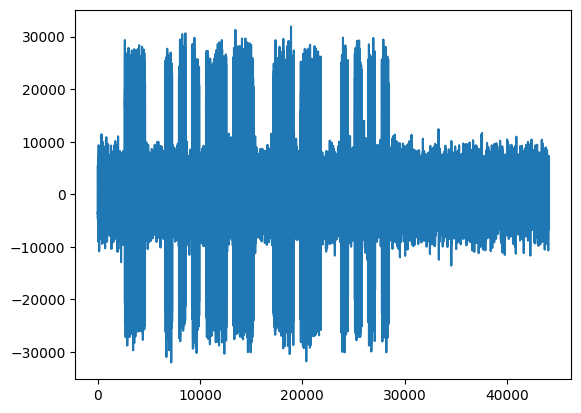

C:\Users\Maor\AppData\Local\Temp\ipykernel_39628\4247521335.py:6: ComplexWarning:

Casting complex values to real discards the imaginary part



In [221]:
random_str = generate_random_word(morse_code_dict, word_length=word_length)
s_i = morse_generator.generate_morse_signal(random_str, snr=snr, apply_noise=True, padding_start=True, padding_end=True,
                                            const_signal_length_sec=const_signal_length_sec)

plt.plot(s_i)
plt.show()
packet_norm = np.int16(packet / np.max(np.abs(packet)) * 32000)
filename = f'.//test.wav'
wavfile.write(filename, sr, packet_norm)
Audio(filename)

## Generate dataset

In [220]:
# generate samples to dict
for i in range(number_of_samples):
    # generate
    random_str = generate_random_word(morse_code_dict, word_length=word_length)
    s_i = morse_generator.generate_morse_signal(random_str, snr=snr, apply_noise=True, padding_start=True,
                                                padding_end=True, const_signal_length_sec=const_signal_length_sec)

    # write to file
    filename = f'{directory_path}//{random_str}.wav'
    wavfile.write(filename, morse_generator.sr, s_i)
    log.debug(f'file #{i}, word="{random_str}" has been saved to: {filename}')

2024-03-23 00:34:32 [DEBUG] root - file #0, word="4KQK" has been saved to: .//test_outputs//4KQK.wav
2024-03-23 00:34:32 [DEBUG] root - file #1, word="UJZM" has been saved to: .//test_outputs//UJZM.wav
2024-03-23 00:34:32 [DEBUG] root - file #2, word="LGME" has been saved to: .//test_outputs//LGME.wav
2024-03-23 00:34:32 [DEBUG] root - file #3, word="LA76" has been saved to: .//test_outputs//LA76.wav
2024-03-23 00:34:32 [DEBUG] root - file #4, word="MOH3" has been saved to: .//test_outputs//MOH3.wav
2024-03-23 00:34:32 [DEBUG] root - file #5, word="SWYV" has been saved to: .//test_outputs//SWYV.wav
2024-03-23 00:34:32 [DEBUG] root - file #6, word="XYKE" has been saved to: .//test_outputs//XYKE.wav
2024-03-23 00:34:32 [DEBUG] root - file #7, word="QAUV" has been saved to: .//test_outputs//QAUV.wav
2024-03-23 00:34:32 [DEBUG] root - file #8, word="XLZL" has been saved to: .//test_outputs//XLZL.wav
2024-03-23 00:34:32 [DEBUG] root - file #9, word="GO X" has been saved to: .//test_outputs/

C:\Users\Maor\AppData\Local\Temp\ipykernel_39628\76156896.py:42: ComplexWarning:

Casting complex values to real discards the imaginary part



## Load dataset
loading all files as <morse string, spectrogram>

In [257]:
directory_path = './/test_outputs'
spectrograms = []
target_strings = []

files = os.listdir(directory_path)
for filename in files:
    if os.path.isfile(os.path.join(directory_path, filename)):
        # read audio file
        _, d = scipy.io.wavfile.read(f'{directory_path}//{filename}')
        d = d.astype(np.float32)
        d /= np.max(np.abs(d))

        # extract morse word to be tokenized
        morse_str, _ = os.path.splitext(filename)

        # get <morse str tokens, spectrogram>
        sxx, token = morse_generator.get_training_sample(d, morse_str)
        spectrograms.append(torch.tensor(sxx))
        target_strings.append(token)
        # dataset.append(morse_generator.get_training_sample(d, morse_str))

dataset = TensorDataset(torch.stack(spectrograms), torch.stack(target_strings))
log.debug(f'{len(files)} files has been loaded to the dataset!')

2024-03-23 21:03:02 [DEBUG] root - 10 files has been loaded to the dataset!


C:\Users\Maor\AppData\Local\Temp\ipykernel_39628\190331490.py:19: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).



# junk

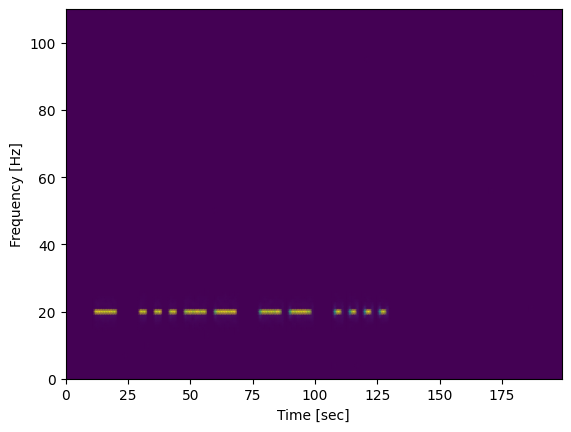

In [222]:
Sxx = morse_generator.get_spectrogram(s_i)
plt.pcolormesh(Sxx, shading='gouraud')
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [sec]')
plt.show()

In [224]:
Sxx.shape

(111, 200)

In [ ]:
_, data1 = scipy.io.wavfile.read('.//test_outputs//XWGM2.wav')
data1 = data1.astype(np.float32)
data1 /= np.max(np.abs(data1))
plt.plot(data1)
plt.show()

# Uses

## Morse Utils

In [1022]:
MORSE_CODE_DICT = {
    'A': '.-', 'B': '-...',
    'C': '-.-.', 'D': '-..', 'E': '.',
    'F': '..-.', 'G': '--.', 'H': '....',
    'I': '..', 'J': '.---', 'K': '-.-',
    'L': '.-..', 'M': '--', 'N': '-.',
    'O': '---', 'P': '.--.', 'Q': '--.-',
    'R': '.-.', 'S': '...', 'T': '-',
    'U': '..-', 'V': '...-', 'W': '.--',
    'X': '-..-', 'Y': '-.--', 'Z': '--..',
    '1': '.----', '2': '..---', '3': '...--',
    '4': '....-', '5': '.....', '6': '-....',
    '7': '--...', '8': '---..', '9': '----.',
    '0': '-----',
    '.': '.-.-.-', ',': '--..--', '?': '..--..',
    '=': '-...-', '+': '.-.-.',
}
ALPHABET = " " + "".join(MORSE_CODE_DICT.keys())
num_tags = len(ALPHABET)


def get_spectrogram(samples, sr, nfft, nperseg, main_freq_idx=None):
    window_length = int(0.02 * SAMPLE_FREQ)  # 20 ms windows
    _, _, sxx = signal.spectrogram(samples, nperseg=window_length, noverlap=0)
    # _, _, sxx = signal.spectrogram(samples, fs=sr, nfft=nfft, nperseg=nperseg, noverlap=int((0.001 * sr)))

    if main_freq_idx != None:
        sxx_filterd = sxx[list(range(main_freq_idx - 2, main_freq_idx + 2)), :]
        return sxx_filterd
    else:
        return sxx


def aggregate_cer(prev_cer, prev_total_chars, y, y_pred):
    new_cer = prev_cer
    new_total_chars = prev_total_chars

    for i in range(len(y)):
        a = prediction_to_str(y[i])
        b = prediction_to_str(torch.argmax(y_pred[i], 1))
        # print(a, b)
        new_cer = calculate_levenshtein_distance(new_cer, new_total_chars, a, b)
        new_total_chars += max(len(a), len(b))

    return new_cer, new_total_chars


def calculate_levenshtein_distance(prev_cer, prev_total_chars, original, predicted):
    d = distance(original, predicted)
    new_total_chars = prev_total_chars + max(len(original), len(predicted))

    return (prev_cer * prev_total_chars + d) / new_total_chars


def calculate_cer(prev_cer, prev_total_chars, original, predicted):
    """
    Computes the Character Error Rate (CER) between the original and predicted strings.
    """
    # Convert strings to lists of characters
    original_chars = list(original)
    predicted_chars = list(predicted)

    # Get the length of the longer string
    max_length = max(len(original_chars), len(predicted_chars))

    # Initialize counters
    errors = 0

    # Iterate over the characters and count errors
    for i in range(max_length):
        try:
            if original_chars[i] != predicted_chars[i]:
                errors += 1
        except IndexError:
            # If the string is shorter, consider the remaining characters as errors
            errors += 1

    if errors > 0:
        print(original, predicted, errors)

    return (prev_cer * prev_total_chars + errors) / (prev_total_chars + max_length)

def find_one_first_element(ndarrays):
    first_index = -1
    last_index = -1
    for i, arr in enumerate(ndarrays):
        if arr[0] == 1:
            if first_index == -1:
                first_index = i
            last_index = i
    return first_index, last_index


def accumulated_length(array_list, start_index, end_index):
    acc_length_start = 0
    for i in range(start_index):
        acc_length_start += len(array_list[i])

    acc_length_end = acc_length_start
    for i in range(start_index, end_index + 1):
        acc_length_end += len(array_list[i])

    return acc_length_start, acc_length_end


def get_signal_bbx(signal_array, spec_time_len, signal_len, main_freq_idx):
    """
    Get signal boundary box
    :param signal_array: 
    :param spec_time_len: 
    :param signal_len: 
    :return: x_start, y_start, x_end, y_end 
    """
    activity_array_start_idx, activity_array_end_idx = find_one_first_element(signal_array)
    time_domain_start_idx, time_domain_end_idx = accumulated_length(signal_array, activity_array_start_idx,
                                                                    activity_array_end_idx)
    alpha = signal_len // spec_time_len
    bbx_idx_start_x = time_domain_start_idx // alpha
    bbx_idx_end_x = time_domain_end_idx // alpha

    return bbx_idx_start_x, main_freq_idx, bbx_idx_end_x, main_freq_idx+1

## Morse Generator

In [1023]:
SAMPLE_FREQ = 2000

def generate_sample(text_len=10, pitch=950, wpm=18, amplitude=100, s=None, main_freq_idx=None, snrDB=0, apply_random_length_dots = True):
    assert pitch < SAMPLE_FREQ / 2  # Nyquist

    # Reference word is PARIS, 50 dots long
    dot = (60 / wpm) / 50 * SAMPLE_FREQ

    # Add some noise on the length of dash and dot
    def get_dot():
        if apply_random_length_dots:
            scale = np.clip(np.random.normal(1, 0.2), 0.5, 2.0)
            return int(dot * scale)
        else:
            return int(dot)

    # The length of a dash is three times the length of a dot.
    def get_dash():
        if apply_random_length_dots:
            scale = np.clip(np.random.normal(1, 0.2), 0.5, 2.0)
            return int(3 * dot * scale)
        else:
            return int(3 * dot)

    # Create random string that doesn't start or end with a space
    if s is None:
        s1 = ''.join(random.choices(ALPHABET, k=text_len - 2))
        s2 = ''.join(random.choices(ALPHABET[1:], k=2))
        s = s2[0] + s1 + s2[1]

    out = []
    out.append(np.zeros(5 * get_dot()))

    # The space between two signs of the same character is equal to the length of one dot.
    # The space between two characters of the same word is three times the length of a dot.
    # The space between two words is seven times the length of a dot (or more).
    for c in s:
        if c == ' ':
            out.append(np.zeros(7 * get_dot()))
        else:
            for m in MORSE_CODE_DICT[c]:
                if m == '.':
                    out.append(np.ones(get_dot()))
                    out.append(np.zeros(get_dot()))
                elif m == '-':
                    out.append(np.ones(get_dash()))
                    out.append(np.zeros(get_dot()))

            out.append(np.zeros(2 * get_dot()))

    out.append(np.zeros(5 * get_dot()))
    out_ = out.copy()
    out = np.hstack(out)

    # Modulation
    t = np.arange(len(out)) / SAMPLE_FREQ
    sine = np.sin(2 * np.pi * t * pitch)
    out = sine * out

    # Add noise
    out = apply_noise_to_signal(out, snrDB)
    out *= amplitude / 100
    out = np.clip(out, -1, 1)
    out = out.astype(np.float32)

    # calculate spectrum
    spec = get_spectrogram(out, sr=SAMPLE_FREQ, nfft=64, nperseg=64, main_freq_idx=main_freq_idx)

    # calculate spec boundaries
    bbx = get_signal_bbx(out_, spec.shape[1], len(out), 19)  # TODO change if main_freq_idx is not used for filtering

    return out, spec, s, bbx

## Example generating 1 signal

pitch: 950, wpm: 18, noise: 11, amplitude: 55, str: QJU7, bbx: (17, 19, 210, 20)


C:\Users\Maor\AppData\Local\Temp\ipykernel_40136\73474619.py:64: ComplexWarning: Casting complex values to real discards the imaginary part
  out = out.astype(np.float32)


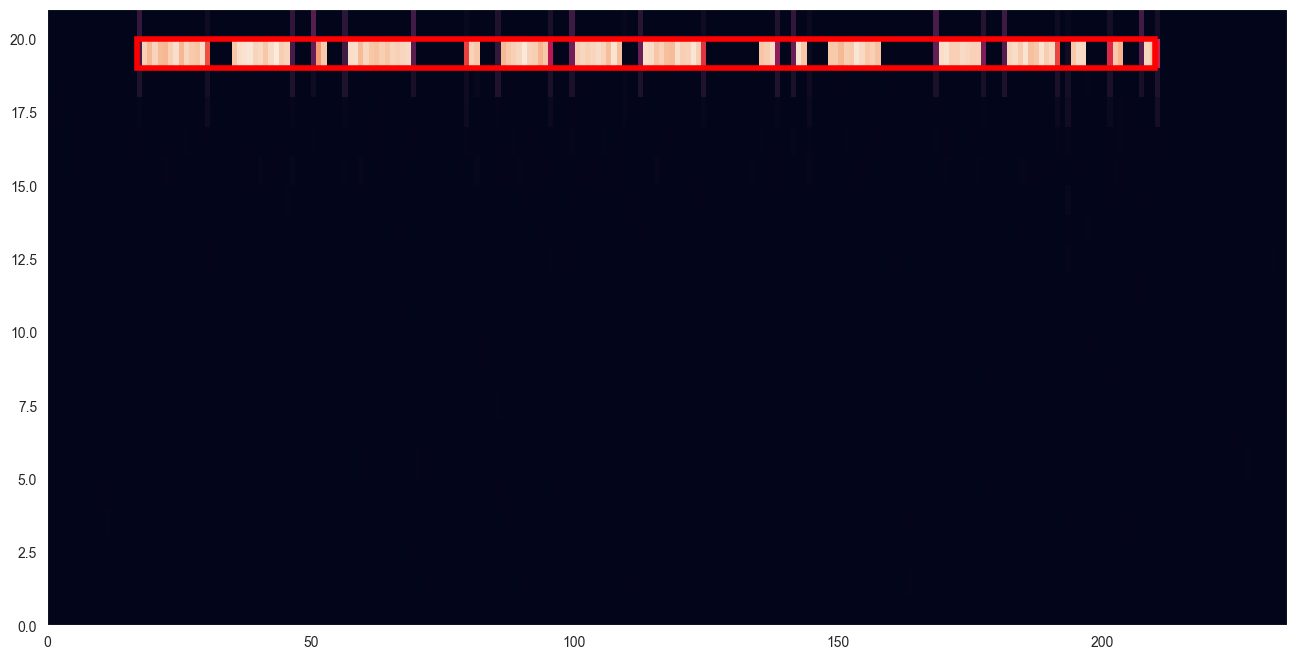

(21, 235)


In [1024]:
length = random.randrange(1, 5)
pitch = 950
wpm = 18
main_freq_idx = 19
# pitch = random.randrange(100, 950)
# wpm = random.randrange(10, 40)
noise_snr = random.randrange(-10, 10)
amplitude = random.randrange(50, 150)

samples, spec, y, bbx = generate_sample(4, pitch, wpm, amplitude, None, None, snrDB=noise_snr, apply_random_length_dots=True)
samples = samples.astype(np.float32)
print(f"pitch: {pitch}, wpm: {wpm}, noise: {noise_power}, amplitude: {amplitude}, str: {y}, bbx: {bbx}")
fig, ax = plt.subplots(1, figsize=(16, 8))
plt.pcolormesh(spec)
rect = patches.Rectangle(
    (bbx[0], bbx[1]),
    bbx[2]-bbx[0],
    bbx[3]-bbx[1],
    linewidth=4,
    edgecolor='red',
    facecolor="none",
)
# Add the patch to the Axes
ax.add_patch(rect)
plt.show()
print(spec.shape)

## Tokenizer

In [1025]:
# 0: blank label
tag_to_idx = {c: i + 1 for i, c in enumerate(ALPHABET)}
idx_to_tag = {i + 1: c for i, c in enumerate(ALPHABET)}

## NN Helpers

In [1026]:
def prediction_to_str(seq):
    if not isinstance(seq, list):
        seq = seq.tolist()

    seq = [i[0] for i in groupby(seq)]  # remove duplicates
    seq = [s for s in seq if s != 0]  # remove blanks
    seq = "".join(idx_to_tag[c] for c in seq)  # convert to string
    seq = seq.rstrip()

    return seq


def get_training_sample(*args, **kwargs):
    _, spec, y, _ = generate_sample(*args, **kwargs)

    spec = torch.from_numpy(spec)
    spec = spec.permute(1, 0)

    y_tags = [tag_to_idx[c] for c in y]
    y_tags = torch.tensor(y_tags)

    return spec, y_tags


def collate_fn_pad(batch):
    xs, ys = zip(*batch)

    input_lengths = torch.tensor([t.shape[0] for t in xs])
    output_lengths = torch.tensor([t.shape[0] for t in ys])

    seqs = nn.utils.rnn.pad_sequence(xs, batch_first=True)
    ys = nn.utils.rnn.pad_sequence(ys, batch_first=True)

    return input_lengths, output_lengths, seqs, ys

## Model Architecture

In [1027]:
class Net(nn.Module):
    def __init__(self, num_tags, spectrogram_size):
        super(Net, self).__init__()

        num_tags = num_tags + 1  # 0: blank
        hidden_dim = 256
        lstm_dim1 = 256

        self.dense1 = nn.Linear(spectrogram_size, hidden_dim)
        self.dropout1 = nn.Dropout(0.1)
        self.dense2 = nn.Linear(hidden_dim, hidden_dim)
        self.dense3 = nn.Linear(hidden_dim, hidden_dim)
        self.dropout2 = nn.Dropout(0.1)
        self.dense4 = nn.Linear(hidden_dim, lstm_dim1)
        self.lstm1 = nn.LSTM(lstm_dim1, lstm_dim1, batch_first=True)
        self.dense5 = nn.Linear(lstm_dim1, num_tags)

    def forward(self, x):
        x = F.relu(self.dense1(x))
        x = self.dropout1(x)
        x = F.relu(self.dense2(x))
        x = self.dropout2(x)
        x = F.relu(self.dense3(x))
        x = F.relu(self.dense4(x))
        # x = self.dropout2(x)
        x, _ = self.lstm1(x)
        x = self.dense5(x)
        x = F.log_softmax(x, dim=2)
        return x

    def count_parameters(self):
        return sum(p.numel() for p in self.parameters() if p.requires_grad)


class Dataset(data.Dataset):
    def __init__(self, number_of_samples=2048, explicit_snr=None):
        self.length = number_of_samples
        self.explicit_snr= explicit_snr

    def __len__(self):
        return self.length

    def __getitem__(self, index):
        length = random.randrange(3, 15)
        pitch = 950
        wpm = 18
        main_freq_idx = 19
        
        if self.explicit_snr != None:
            noise_snr = self.explicit_snr
        else:
            noise_snr = random.randrange(-10, 10)
            
        amplitude = random.randrange(50, 200)

        return get_training_sample(length, pitch, wpm, amplitude, None, None, noise_snr, True)

## Training loop
launch tensorboard with CLI 
tensorboard --logdir C:/Users/Maor/Desktop/dev/tensorboard/morse-dl/runs

In [1030]:
tf_board_log_dir_path = "C:/Users/Maor/Desktop/dev/tensorboard/morse-dl/runs"  # path without hebrew unicode chars
batch_size = 64
spectrogram_size = generate_sample()[1].shape[0]

device = torch.device("cuda")
writer = SummaryWriter(tf_board_log_dir_path)

# Set up trainer & evaluator
model = Net(num_tags, spectrogram_size).to(device)
print("Number of params", model.count_parameters())

# Lower learning rate to 1e-4 after about 1500 epochs
optimizer = optim.Adam(model.parameters(), lr=0.0001, betas=(0.9, 0.999))
ctc_loss = nn.CTCLoss()

train_loader = torch.utils.data.DataLoader(
    Dataset(number_of_samples=2048),
    batch_size=batch_size,
    collate_fn=collate_fn_pad,
)

random.seed(0)

# run_date = datetime.now().strftime("%Y-%m-%d_%H-%M-%S")
run_date = '2024-03-26_01-45-23'
epoch = 1840
epochs = epoch + 501
losses = []

# Resume training
if epoch != 0:
    model.load_state_dict(torch.load(f"models/{run_date}_{epoch:06}.pt", map_location=device))
    # state_dict = torch.load(f"models/{run_date}_{epoch:06}.pt")
    # model.dense1.weight = torch.nn.Parameter(state_dict["dense1.weight"])
    # model.dense1.bias = torch.nn.Parameter(state_dict["dense1.bias"])
    # model.dense2.weight = torch.nn.Parameter(state_dict["dense2.weight"])
    # model.dense2.bias = torch.nn.Parameter(state_dict["dense2.bias"])
    # model.dense3.weight = torch.nn.Parameter(state_dict["dense3.weight"])
    # model.dense3.bias = torch.nn.Parameter(state_dict["dense3.bias"])
    # model.dense4.weight = torch.nn.Parameter(state_dict["dense4.weight"])
    # model.dense4.bias = torch.nn.Parameter(state_dict["dense4.bias"])
    # model.dense5.weight = torch.nn.Parameter(state_dict["dense5.weight"])
    # model.dense5.bias = torch.nn.Parameter(state_dict["dense5.bias"])
    # model.lstm1.weight_ih_l0.data = torch.nn.Parameter(state_dict["lstm1.weight_ih_l0"])
    # model.lstm1.weight_hh_l0.data = torch.nn.Parameter(state_dict["lstm1.weight_hh_l0"])
    # model.lstm1.bias_ih_l0.data = torch.nn.Parameter(state_dict["lstm1.bias_ih_l0"])
    # model.lstm1.bias_hh_l0.data = torch.nn.Parameter(state_dict["lstm1.bias_hh_l0"])
    print(f'Model has been loaded from prev state of epoch: {epoch}')

model.train()
while epoch < epochs:
    train_loss = 0
    curr_cer = 1.0
    total_chars = 0

    for (input_lengths, output_lengths, x, y) in train_loader:
        x, y = x.to(device), y.to(device)

        optimizer.zero_grad()
        y_pred = model(x)

        m = torch.argmax(y_pred[0], 1)
        curr_cer, total_chars = aggregate_cer(curr_cer, total_chars, y, y_pred)
        y_pred = y_pred.permute(1, 0, 2)

        loss = ctc_loss(y_pred, y, input_lengths, output_lengths)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()

    writer.add_scalar(f"training/{run_date}_loss", train_loss / len(train_loader), epoch)
    writer.add_scalar(f"training/{run_date}_lvstn", curr_cer * 100, epoch)
    if epoch % 10 == 0:
        torch.save(model.state_dict(), f"models/{run_date}_{epoch:06}.pt")

    losses.append(train_loss / len(train_loader))
    print(
        f'Epoch #{epoch}| (e.g. target: {prediction_to_str(y[0])}, pred: {prediction_to_str(m)}), loss: {loss.item():2f}, CER: {curr_cer * 100:1f}% on {total_chars} chars')
    epoch += 1

C:\Users\Maor\AppData\Local\Temp\ipykernel_40136\73474619.py:64: ComplexWarning: Casting complex values to real discards the imaginary part
  out = out.astype(np.float32)


Number of params 740395
Model has been loaded from prev state of epoch: 1840
Epoch #1840| (e.g. target: YT.4ZO1S0Z, pred: YT.4ZO1S0Z), loss: 0.033064, CER: 4.098740% on 17298 chars


KeyboardInterrupt: 

## Evaluation loop vs SNR

In [1031]:
snrs = [-15, -10, -5, 0, 5, 10, 15]
cers = []
val_losses = []

for i in range(len(snrs)):
    print('Validating model for snr: ', snrs[i])
    
    val_loader = torch.utils.data.DataLoader(
        Dataset(number_of_samples=2048, explicit_snr=snrs[i]),
        batch_size=batch_size,
        collate_fn=collate_fn_pad,
    )
    val_loss = 0.0
    curr_cer = 1.0
    total_chars = 0
    
    model.eval()
    with torch.no_grad():
        for (input_lengths, output_lengths, x, y) in val_loader:
            x, y = x.to(device), y.to(device)
    
            # Forward pass
            y_pred = model(x)
    
            # Compute loss
            m = torch.argmax(y_pred[0], 1)
            curr_cer, total_chars = aggregate_cer(curr_cer, total_chars, y, y_pred)
            y_pred = y_pred.permute(1, 0, 2)
        
            loss = ctc_loss(y_pred, y, input_lengths, output_lengths)
            val_loss += loss.item()
            
    val_losses.append(val_loss/len(val_loader))
    cers.append(curr_cer)

Validating model for snr:  -15


C:\Users\Maor\AppData\Local\Temp\ipykernel_40136\73474619.py:64: ComplexWarning: Casting complex values to real discards the imaginary part
  out = out.astype(np.float32)


Validating model for snr:  -10
Validating model for snr:  -5
Validating model for snr:  0
Validating model for snr:  5
Validating model for snr:  10
Validating model for snr:  15


## Visualize

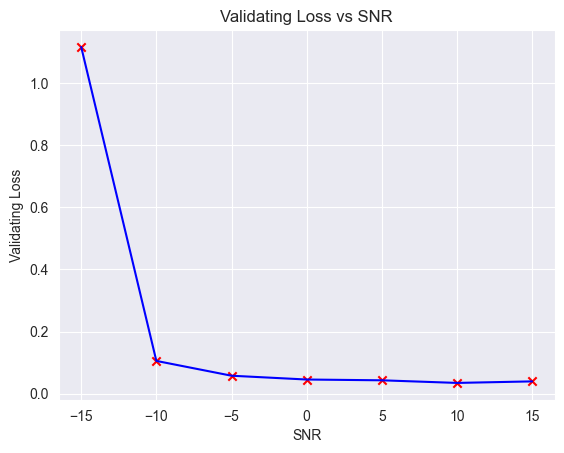

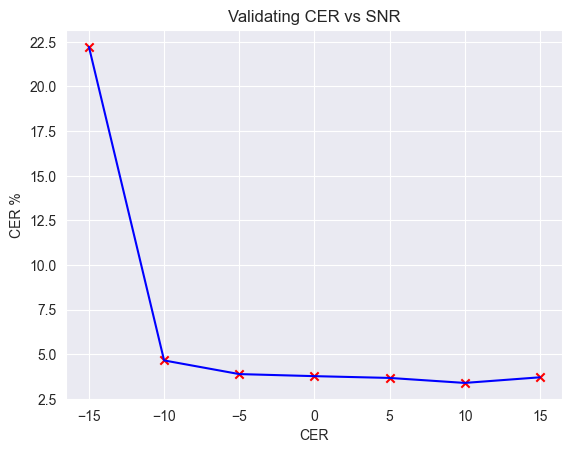

In [1051]:
plt.plot(snrs, val_losses, color='blue')
plt.scatter(snrs, val_losses, marker='x', color='red') 
plt.xlabel('SNR')
plt.ylabel('Validating Loss')
plt.title('Validating Loss vs SNR')
plt.show()

plt.plot(snrs, [100*c for c in cers], color='blue')
plt.scatter(snrs, [100*c for c in cers], marker='x', color='red')
plt.xlabel('CER')
plt.ylabel('CER %')
plt.title('Validating CER vs SNR')
plt.show()

## Example of tensorboard add images

In [431]:
from torchvision.utils import make_grid

for i, image_tensor in enumerate([torch.tensor(spec), torch.tensor(spec)]):
    img_grid = make_grid(image_tensor, nrow=8)  # Show 8 images per row
    writer.add_image(f"Training data", img_grid, i)

# Approaches

## LSTM + RNN

### Dataset

### Model Architecture

### Utils

### Training

## Faster R-CNN

### imports

In [741]:
import sys
import numpy as np
import cv2
import os
from datetime import datetime
from PIL import Image
import torch
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torch.utils.data import Dataset, DataLoader, Subset
import torchvision.transforms.functional as F
from sklearn.model_selection import train_test_split
from tqdm import tqdm
from matplotlib import pyplot as plt
import pickle
import pandas as pd
import glob as glob
import random

### Example

In [742]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print("We use the following device: ", device)
# load a model; pre-trained on COCO
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(weights='COCO_V1').to(device)

We use the following device:  cuda


Downloading: "https://download.pytorch.org/models/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth" to C:\Users\Maor/.cache\torch\hub\checkpoints\fasterrcnn_resnet50_fpn_coco-258fb6c6.pth
100%|██████████| 160M/160M [00:18<00:00, 9.09MB/s] 


In [743]:
def img_transform(img):
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB).astype(np.float32)
    img /= 255.0
    img = torch.from_numpy(img).permute(2,0,1)
    return img

In [744]:
def inference(img, model, detection_threshold=0.70):
    '''
    Infernece of a single input image
  
    inputs:
      img: input-image as torch.tensor (shape: [C, H, W])
      model: model for infernce (torch.nn.Module)
      detection_threshold: Confidence-threshold for NMS (default=0.7)
  
    returns:
      boxes: bounding boxes (Format [N, 4] => N times [xmin, ymin, xmax, ymax])
      labels: class-prediction (Format [N] => N times an number between 0 and _num_classes-1)
      scores: confidence-score (Format [N] => N times confidence-score between 0 and 1)
    '''
    model.eval()

    img = img.to(device)
    outputs = model([img])

    boxes = outputs[0]['boxes'].data.cpu().numpy()
    scores = outputs[0]['scores'].data.cpu().numpy()
    labels = outputs[0]['labels'].data.cpu().numpy()

    boxes = boxes[scores >= detection_threshold].astype(np.int32)
    labels = labels[scores >= detection_threshold]
    scores = scores[scores >= detection_threshold]

    return boxes, scores, labels

In [790]:
def plot_image(img, boxes, scores, labels, dataset, save_path=None):
    '''
    Function that draws the BBoxes, scores, and labels on the image.
  
    inputs:
      img: input-image as numpy.array (shape: [H, W, C])
      boxes: list of bounding boxes (Format [N, 4] => N times [xmin, ymin, xmax, ymax])
      scores: list of conf-scores (Format [N] => N times confidence-score between 0 and 1)
      labels: list of class-prediction (Format [N] => N times an number between 0 and _num_classes-1)
      dataset: list of all classes e.g. ["background", "class1", "class2", ..., "classN"] => Format [N_classes]
    '''

    cmap = plt.get_cmap("tab20b")
    class_labels = np.array(dataset)
    colors = [cmap(i) for i in np.linspace(0, 1, len(class_labels))]
    height, width, _ = img.shape
    # Create figure and axes
    fig, ax = plt.subplots(1, figsize=(16, 8))
    # Display the image
    ax.imshow(img)
    for i, box in enumerate(boxes):
        class_pred = labels[i]
        conf = scores[i]
        width = box[2] - box[0]
        height = box[3] - box[1]
        rect = patches.Rectangle(
            (box[0], box[1]),
            width,
            height,
            linewidth=4,
            edgecolor=colors[int(class_pred)],
            facecolor="none",
        )
        # Add the patch to the Axes
        ax.add_patch(rect)
        plt.text(
            box[0], box[1],
            s=class_labels[int(class_pred)] + " " + str(int(100*conf)) + "%",
            color="white",
            verticalalignment="top",
            bbox={"color": colors[int(class_pred)], "pad": 0},
        )

    # Used to save inference phase results
    if save_path is not None:
        plt.savefig(save_path)

    plt.show()

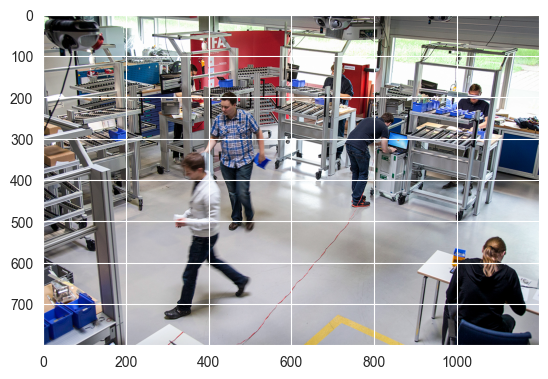

In [779]:
img = cv2.imread("C://Users//Maor//Downloads//produktion_und_logistik_master.jpg")
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))

In [749]:
img = img_transform(img)
boxes, scores, labels = inference(img, model)

In [750]:
with open("C://Users//Maor//Downloads//coco_labels.txt", "r") as coco:
    COCO_LABELS = coco.readlines()

for i, _ in enumerate(COCO_LABELS):
    COCO_LABELS[i] = COCO_LABELS[i].replace("\n", "")

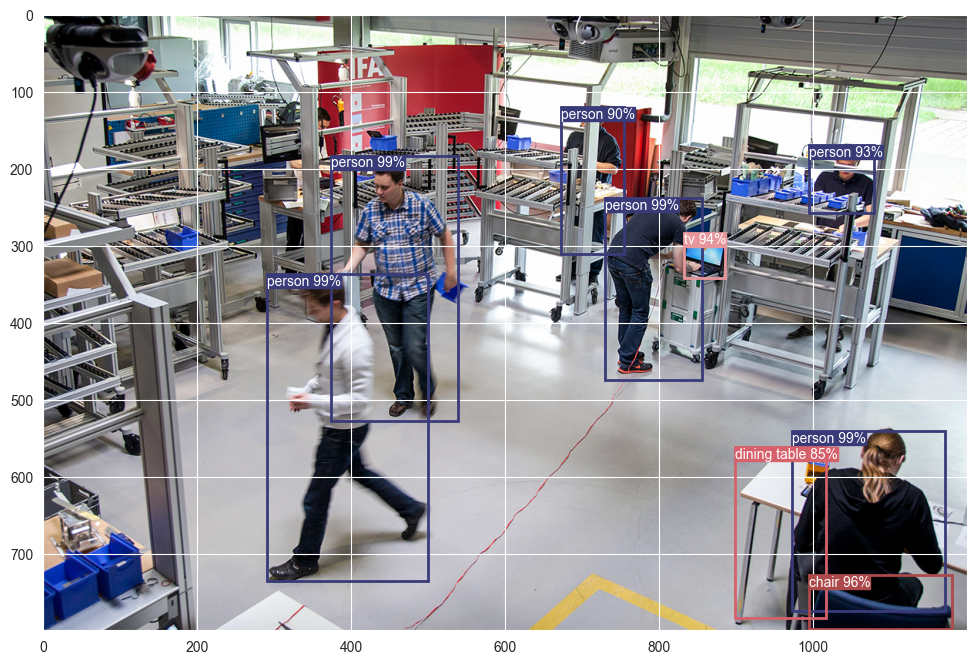

In [751]:
img = img.cpu().permute(1,2,0).numpy()
plot_image(img, boxes, scores, labels, COCO_LABELS)

### Morse Example (plotting)

In [881]:
def spectrum_to_img(spec):
    
    # Normalize the spectrum (min-max scaling)
    min_value = np.min(spec)
    max_value = np.max(spec)
    normalized_spectrum = (spec - min_value) / (max_value - min_value)

    normalized_spectrum = np.expand_dims(normalized_spectrum, axis=-1)
    normalized_spectrum = torch.from_numpy(normalized_spectrum).permute(2,0,1)
    
    return normalized_spectrum

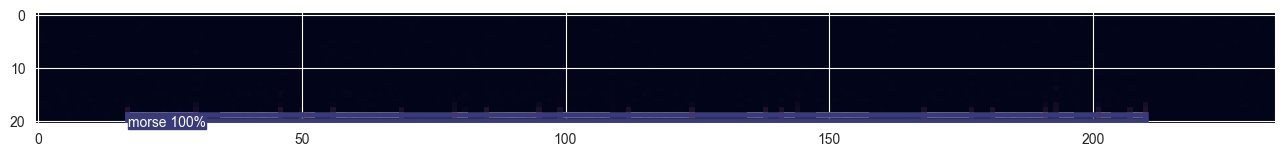

In [1069]:
img_spec = spectrum_to_img(spec).permute(1,2,0)
plot_image(img_spec, np.array(bbx).reshape(1, -1), [1.0], [0], ['morse'])

### Morse Preprocessing

In [1055]:
def get_training_sample_bbx(*args, **kwargs):
    _, spec, _, bbx = generate_sample(*args, **kwargs)
    spec = spectrum_to_img(spec)

    return spec, bbx


class DatasetBBX(data.Dataset):
    def __init__(self, number_of_samples=2048):
        self.length = number_of_samples

    def __len__(self):
        return self.length

    def __getitem__(self, index):
        target = {}
        
        # random params
        length = random.randrange(1, 9)
        pitch = 950
        wpm = 18
        noise_snr = random.randrange(-10, 10)
        amplitude = random.randrange(50, 200)
        spec, bbx = get_training_sample_bbx(length, pitch, wpm, amplitude, None, None, snrDB=noise_snr, apply_random_length_dots=True)
        
        target["boxes"] = torch.Tensor([bbx]).float()
        target["labels"] = torch.LongTensor([0])
        
        return spec, target

### training

#### Hyperparameter

In [1056]:
# Hyperparameters
SEED = 42
TEST_SIZE = 0.2
NUM_EPOCHS = 5

LR = 0.005
LR_MOMENTUM=0.9
LR_DECAY_RATE=0.0005

LR_SCHED_STEP_SIZE = 0.1
LR_SCHED_GAMMA = 0.1

BATCH_SIZE = 64

NUM_TEST_IMAGES = 5
NMS_THRESH = 0.01

OUTPUT_DIR = 'faster_rnn_outputs'

#### Model init

In [1057]:
labels = ['morse']
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

# [2 up to 9] morse chars max img size is ~550
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(min_size=50, max_size=550, pretrained=True)
num_classes = 1
in_features = model.roi_heads.box_predictor.cls_score.in_features
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)
model.to(device)

num_epochs = NUM_EPOCHS

# construct an optimizer
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=LR, momentum=LR_MOMENTUM, weight_decay=LR_DECAY_RATE)

# create a train- and validation-dataset with our vehicleDataset
# split the dataset in train and test set
dataset = DatasetBBX()
dataset_test = DatasetBBX()

torch.manual_seed(SEED)
indices = torch.randperm(len(dataset)).tolist()

test_size = int(len(dataset) * TEST_SIZE)
dataset = torch.utils.data.Subset(dataset, indices[:-test_size])
dataset_test = torch.utils.data.Subset(dataset_test, indices[-test_size:])

# create a learning rate scheduler
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, \
                                               step_size=LR_SCHED_STEP_SIZE, \
                                               gamma=LR_SCHED_GAMMA)

def collate_fn(batch):
    return tuple(zip(*batch))

# define training and validation data loaders
data_loader = torch.utils.data.DataLoader(
    dataset, batch_size=BATCH_SIZE, shuffle=True,
    collate_fn=collate_fn)

data_loader_test = torch.utils.data.DataLoader(
    dataset_test, batch_size=1, shuffle=False,
    collate_fn=collate_fn)

#### Training functions

In [1058]:
'''
Function to train the model over one epoch.
'''
def train_one_epoch(model, optimizer, data_loader, device, epoch):
    train_loss_list = []

    tqdm_bar = tqdm(data_loader, total=len(data_loader))
    for idx, data in enumerate(tqdm_bar):
        optimizer.zero_grad()
        images, targets = data

        images = list(image.to(device) for image in images)
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]  # targets = {'boxes'=tensor, 'labels'=tensor}

        losses = model(images, targets)

        loss = sum(loss for loss in losses.values())
        # loss_val = loss.item()
        train_loss_list.append(loss.detach().cpu().numpy())

        loss.backward()
        optimizer.step()

        tqdm_bar.set_description(desc=f"Training Loss: {loss:.3f}")

    return train_loss_list

'''
Function to validate the model
'''
def evaluate(model, data_loader_test, device):
    val_loss_list = []

    tqdm_bar = tqdm(data_loader_test, total=len(data_loader_test))

    for i, data in enumerate(tqdm_bar):
        images, targets = data

        images = list(image.to(device) for image in images)
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

        with torch.no_grad():
            losses = model(images, targets)

        loss = sum(loss for loss in losses.values())
        loss_val = loss.item()
        val_loss_list.append(loss_val)

        tqdm_bar.set_description(desc=f"Validation Loss: {loss:.4f}")
    return val_loss_list

'''
Function to plot training and valdiation losses and save them in `output_dir'
'''
def plot_loss(train_loss, valid_loss):
    figure_1, train_ax = plt.subplots()
    figure_2, valid_ax = plt.subplots()

    train_ax.plot(train_loss, color='blue')
    train_ax.set_xlabel('Iteration')
    train_ax.set_ylabel('Training Loss')

    valid_ax.plot(valid_loss, color='red')
    valid_ax.set_xlabel('Iteration')
    valid_ax.set_ylabel('Validation loss')

    figure_1.savefig(f"{OUTPUT_DIR}/train_loss.png")
    figure_2.savefig(f"{OUTPUT_DIR}/valid_loss.png")

### Load from checkpoint

In [1059]:
# find latest saved chcekpoint
checkpoint_files = [f for f in os.listdir(OUTPUT_DIR) if f.endswith('.pth')]
if checkpoint_files:
    # Last ckpt file
    checkpoint_files.sort()
    latest_checkpoint = os.path.join(OUTPUT_DIR, checkpoint_files[-1])

    # Load the ckpt
    checkpoint = torch.load(latest_checkpoint)
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    start_epoch = checkpoint['epoch']
    loss_dict = checkpoint['loss_dict']
else:
    start_epoch = 0
    loss_dict = {'train_loss': [], 'valid_loss': []}

#### Train

In [ ]:
'''
Train the model over all epochs
'''
for epoch in range(start_epoch, num_epochs):
    print("----------Epoch {}----------".format(epoch+1))

    # Train the model for one epoch
    train_loss_list = train_one_epoch(model, optimizer, data_loader, device, epoch)
    loss_dict['train_loss'].extend(train_loss_list)

    lr_scheduler.step()

    # Run evaluation
    valid_loss_list = evaluate(model, data_loader_test, device)
    loss_dict['valid_loss'].extend(valid_loss_list)

    # Svae the model ckpt after every epoch
    ckpt_file_name = f"{OUTPUT_DIR}/epoch_{epoch+1}_model.pth"
    torch.save({
        'epoch': epoch+1,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'loss_dict': loss_dict
    }, ckpt_file_name)

    # NOTE: The losses are accumulated over all iterations
    plot_loss(loss_dict['train_loss'], loss_dict['valid_loss'])

# Store the losses after the training in a pickle
with open(f"{OUTPUT_DIR}/loss_dict.pkl", "wb") as file:
    pickle.dump(loss_dict, file)

print("Training Finished !")

### Testing

C:\Users\Maor\AppData\Local\Temp\ipykernel_40136\73474619.py:64: ComplexWarning: Casting complex values to real discards the imaginary part
  out = out.astype(np.float32)


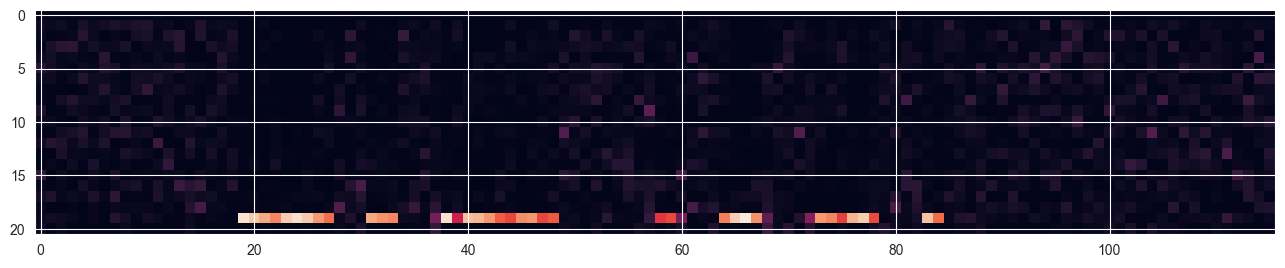

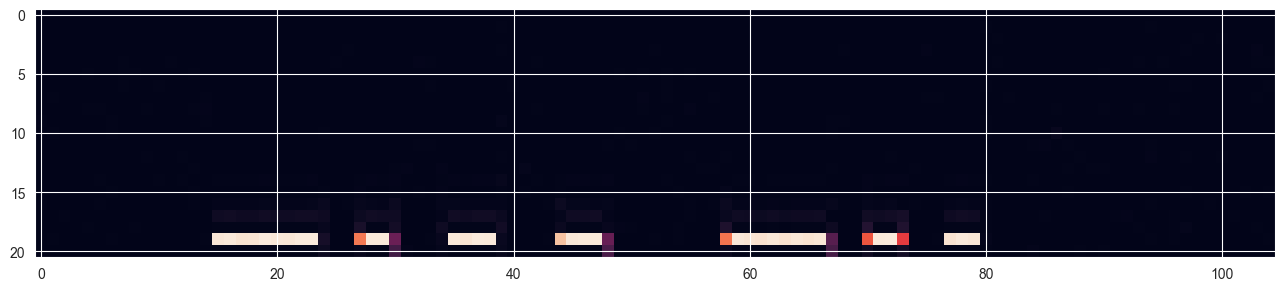

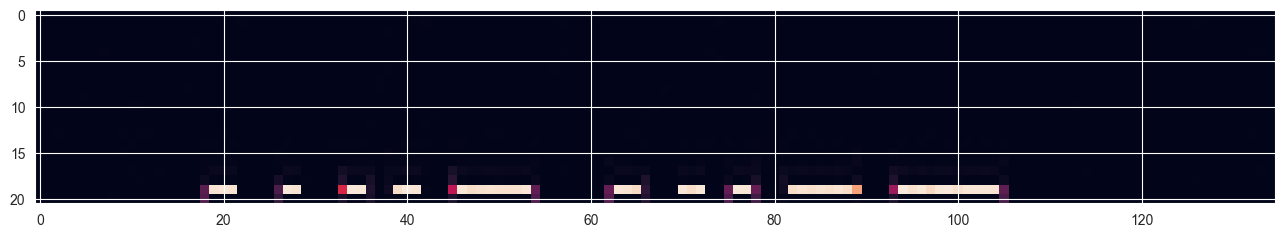

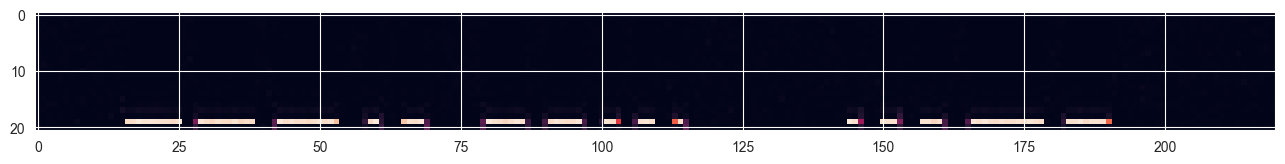

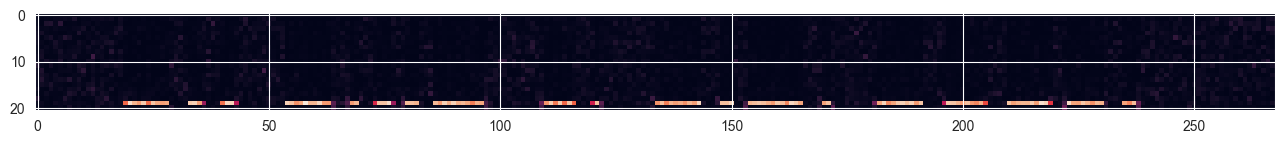

In [1082]:
random.seed(SEED)
num_images = NUM_TEST_IMAGES

# Load last checkpoint
# CHANGE THE OUTPUT_DIR IF CKPT IS STORED ELSEWHERE
checkpoint_dir = f"{OUTPUT_DIR}/epoch_2_model.pth"
checkpoint = torch.load(checkpoint_dir, map_location=device)
model.load_state_dict(checkpoint['model_state_dict'])

for _ in range(num_images):
    x = random.randint(0, (dataset_test.__len__()-1))
    img, target = dataset_test.__getitem__(x)
    img = img.to(device)

    boxes, scores, labels = inference(img, model)

    plot_image(img.cpu().permute(1,2,0), boxes, scores, labels, ['morse'], save_path=f"{OUTPUT_DIR}/inference_{x}.png")